# Clustering ISGs  for HBECs

In [2]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
# from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools
import random
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_rows', 600)

In [3]:
import functools

In [4]:
import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')
# sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
# import encode
import memento

In [5]:
data_path = '/home/ubuntu/Data/hbec/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [6]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [7]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Get data

In [8]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

/home/ubuntu/anaconda3/envs/mementocxg/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [9]:
# adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [10]:
adata.shape

(69958, 36601)

In [11]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [12]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])
# adata_processed.obs['ct'] = adata_processed.obs['cell_type'].apply(lambda x: converter[x])

### Setup memento

In [13]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [14]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [15]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

In [16]:
ct = ['C']


### Compute coexpression

In [17]:
def get_gxg_matrix(adata, genes):

    memento.compute_2d_moments(adata, list(itertools.combinations(genes, 2)))
    
    moments = memento.get_2d_moments(adata, groupby='group')
    
    gxg_matrix = pd.DataFrame(index=genes, columns=genes)
    for idx, row in moments.iterrows():
        gxg_matrix.loc[row['gene_1'], row['gene_2']] = row['group_1']
        gxg_matrix.loc[row['gene_2'], row['gene_1']] = row['group_1']
    gxg_matrix = gxg_matrix.fillna(0.0)
#     gxg_matrix = moments.pivot('gene_1', 'gene_2', 'group_1').fillna(0.0)
#     gxg_matrix[gxg_matrix.columns] = gxg_matrix.values + gxg_matrix.values.T
    gxg_matrix = gxg_matrix.loc[list(set(gxg_matrix.columns) & set(gxg_matrix.index)), list(set(gxg_matrix.columns) & set(gxg_matrix.index))]
    
    return gxg_matrix

In [18]:
ct = ['C']
adata_ctrl = adata.copy()[
    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['control'])].copy()
adata_stim = adata.copy()[
    adata.obs.time.isin(['6']) & \
    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['beta'])].copy()
adata_gamma = adata.copy()[
    adata.obs.time.isin(['6']) & \
    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['gamma'])].copy()
adata_ctrl.obs['group'] = 1
adata_stim.obs['group'] = 1
adata_gamma.obs['group'] = 1

memento.create_groups(adata_ctrl, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)
memento.create_groups(adata_stim, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)
memento.create_groups(adata_gamma, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_gamma, min_perc_group=.9)
# gamma_gxg = get_gxg_matrix(adata_gamma, gene_list)

### Read gene groups

In [19]:
with open('canonical_isgs.pkl', 'rb') as f:
    canonical_genes = pkl.load(f)
with open('noncanonical_isgs.pkl', 'rb') as f:
    noncanonical_genes_1 = pkl.load(f)
np.random.shuffle(noncanonical_genes_1)

In [20]:
# noncanonical_genes_1 = subset_stim_gxg.index[clustering.labels_==1].tolist()
# noncanonical_genes_2 = subset_stim_gxg.index[clustering.labels_==2].tolist()

# noncanonical_genes_3 = subset_stim_gxg.index[clustering.labels_==8].tolist()

# noncanonical_genes_2 = subset_stim_gxg.index[clustering.labels_==6].tolist()

In [21]:
all_selected_genes = canonical_genes + noncanonical_genes_1 #+ noncanonical_genes_3 + noncanonical_genes_2

In [22]:
print(noncanonical_genes_1)

['RNF13', 'HLA-A', 'TRIM69', 'FBXO6', 'PLAAT4', 'MUC15', 'GMDS', 'SNX6', 'DRAP1', 'CASP1', 'CD164', 'PHF11', 'B2M', 'VAMP5', 'PSMF1', 'SLC44A1', 'CD47', 'RBCK1', 'FYTTD1', 'APOBEC3F', 'CNP', 'MT2A', 'GLIPR2', 'PSMB10', 'IGFBP4', 'TNFSF13', 'SECTM1', 'HIST2H2AA4', 'CCND3', 'GBP3', 'CFH', 'RPS6KC1', 'SCAMP1-AS1', 'SERPING1', 'BCL2L13', 'SH3KBP1', 'NMI', 'ACSS2', 'ENDOD1', 'HLA-B', 'TLR3', 'ECHS1', 'CARD16', 'LGMN', 'FBXO7', 'HLA-F', 'IFIT5', 'IFI30', 'TCHP', 'PSMA2', 'NDUFA9', 'HM13', 'RABAC1', 'HLA-C', 'TNFRSF14', 'GRINA', 'MT1E', 'CCDC71L', 'KAT2B', 'IFITM2', 'BAK1', 'AZI2', 'NAPA', 'RNF114', 'IRF1', 'TOR1B', 'GMPR', 'PSME2', 'TSPAN13', 'EHD4', 'BTC', 'GLRX']


In [23]:
gene_list = list( set(adata_ctrl.var.index) & set(adata_stim.var.index) & set(all_selected_genes ))

ctrl_gxg = get_gxg_matrix(adata_ctrl, gene_list)
stim_gxg = get_gxg_matrix(adata_stim, gene_list)

In [24]:
np.fill_diagonal(ctrl_gxg.values, 1)
np.fill_diagonal(stim_gxg.values, 1)

([], [])

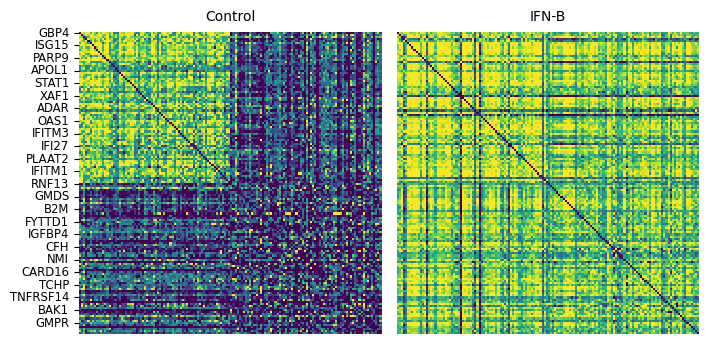

In [25]:
plt.figure(figsize=(8,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(1, 2, 1);
plt.title('Control')
sns.heatmap(ctrl_gxg.loc[all_selected_genes, all_selected_genes], vmin=0.1, vmax=0.7, cmap='viridis', cbar=None)
plt.axis('equal')
plt.xticks([])

plt.subplot(1, 2, 2);
plt.title('IFN-B')
sns.heatmap(stim_gxg.loc[all_selected_genes, all_selected_genes], vmin=0.1, vmax=0.7, cmap='viridis', cbar=None)
plt.axis('equal')
plt.xticks([])
plt.yticks([])

In [26]:
coex = ctrl_gxg.loc[all_selected_genes, all_selected_genes]

### Investigate other timepoints - coexpression

In [27]:
tps = ['3', '6', '9', '24', '48']

In [28]:
gxg_matrices = {}
for tp in tps:
    
    adata_tp = adata.copy()[
        adata.obs.time.isin([tp]) & \
        adata.obs.ct.isin(ct) & \
        adata.obs.stim.isin(['beta'])].copy()
    adata_tp.obs['group'] = 1

    memento.create_groups(adata_tp, label_columns=['donor', 'group'])
    memento.compute_1d_moments(adata_tp, min_perc_group=.9)
    
    tp_gene_list = [g for g in all_selected_genes if g in adata_tp.var.index]

    gxg_matrices[tp] = get_gxg_matrix(adata_tp, tp_gene_list).loc[tp_gene_list, tp_gene_list]
    np.fill_diagonal(gxg_matrices[tp].values, 1)


In [47]:
# Generate inner circles
R_inner = 1
R_outer = 2.5
PI = np.pi
centerX, centerY = 0, 0
pos = {}

for g in canonical_genes:

    r = R_inner * np.sqrt(random.random())
    theta = random.random() * 2 * PI
    x = centerX + r * np.cos(theta)
    y = centerY + r * np.sin(theta)
    pos[g] = np.array([x,y])

for g in noncanonical_genes_1:

    r = (R_outer-R_inner) * np.sqrt(random.random()) + R_inner
    theta = random.random() * 2 * PI
    x = centerX + r * np.cos(theta)
    y = centerY + r * np.sin(theta)
    pos[g] = np.array([x,y])

def draw_coex_network(coex, pos, corr_thresh, alpha):


    G = nx.Graph()
    edge_list = []
    for i in range(coex.shape[0]):
        for j in range(i+1, coex.shape[1]):
            G.add_edge(coex.index[i], coex.index[j], weight=coex.iloc[i,j])
            if coex.iloc[i,j] > corr_thresh:
                edge_list.append((coex.index[i], coex.index[j]))

    nx.draw_networkx_edges(G, pos=pos, edgelist=edge_list, alpha=alpha, edge_color='black')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=canonical_genes, node_color='cyan', node_size=3.5)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=noncanonical_genes_1, node_color='magenta', node_size=3.5)

    plt.axis('off')

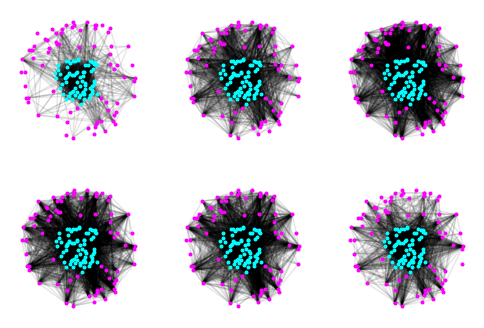

In [49]:
plt.figure(figsize=(6,4))
# plt.subplots_adjust(wspace=0.05)

plt.subplot(2, 3, 1);
draw_coex_network(ctrl_gxg.loc[all_selected_genes, all_selected_genes], pos, corr_thresh=0.6, alpha=0.1)
for i, tp in enumerate(tps):

    plt.subplot(2, 3, 2+i);
    draw_coex_network(gxg_matrices[tp], pos, corr_thresh=0.6, alpha=0.1)
plt.savefig('coex_hairball.png', bbox_inches='tight')

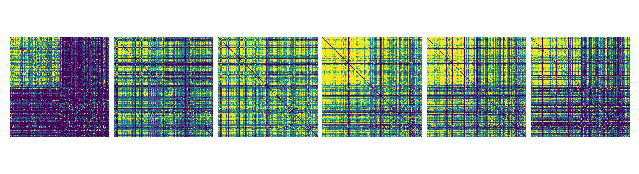

In [40]:
plt.figure(figsize=(8,2))
plt.subplots_adjust(wspace=0.05)
vmax=0.7
vmin=0.23

cmap = plt.get_cmap('viridis')
vals = np.vstack([
    cmap(np.linspace(0, 0.5, 200)),
    cmap(np.linspace(0.5, 1, 100))])
mycmap = colors.LinearSegmentedColormap.from_list('viridis', vals)

# mycmap='viridis'

plt.subplot(1, 6, 1);
# plt.title('Control')
sns.heatmap(ctrl_gxg.loc[all_selected_genes, all_selected_genes], vmin=vmin, vmax=vmax, cmap=mycmap, cbar=None)
plt.axis('equal')
plt.xticks([])
plt.yticks([])

for i, tp in enumerate(tps):

    plt.subplot(1, 6, i+2);
#     plt.title('IFN-B ' + tps[i] + 'hr')
    sns.heatmap(gxg_matrices[tp], vmin=vmin, vmax=vmax, cmap=mycmap, cbar=None)
    # sns.heatmap(gxg_matrices[tp], cmap=mycmap, cbar=None, center=0.0)

    plt.axis('equal')
    plt.xticks([]);
    plt.yticks([])
# plt.savefig('ifnb_coex_tps.png', bbox_inches='tight', dpi=500)

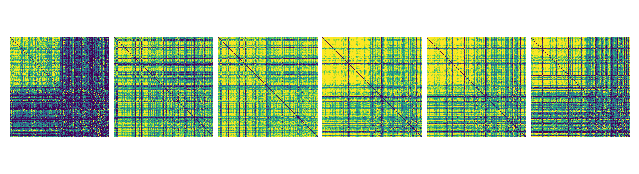

In [136]:
plt.figure(figsize=(8,2))
plt.subplots_adjust(wspace=0.05)
vmax=0.7
vmin=0.1

vals = np.vstack([
    cmap(np.linspace(0, 0.5, 500)),
    cmap(np.linspace(0.5, 1, 100))])
mycmap = colors.LinearSegmentedColormap.from_list('viridis', vals)

mycmap='viridis'

plt.subplot(1, 6, 1);
# plt.title('Control')
sns.heatmap(ctrl_gxg.loc[all_selected_genes, all_selected_genes], vmin=vmin, vmax=vmax, cmap=mycmap, cbar=None)
plt.axis('equal')
plt.xticks([])
plt.yticks([])

for i, tp in enumerate(tps):

    plt.subplot(1, 6, i+2);
#     plt.title('IFN-B ' + tps[i] + 'hr')
    sns.heatmap(gxg_matrices[tp], vmin=vmin, vmax=vmax, cmap=mycmap, cbar=None)
    # sns.heatmap(gxg_matrices[tp], cmap=mycmap, cbar=None, center=0.0)

    plt.axis('equal')
    plt.xticks([]);
    plt.yticks([])
# plt.savefig('ifnb_coex_tps.png', bbox_inches='tight', dpi=500)

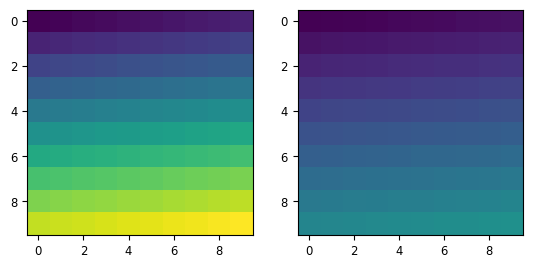

In [137]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n))
    
    )
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('viridis')
new_cmap = truncate_colormap(cmap, 0.0, 0.5)
minval = 0
maxval = 0.5
trunc = 'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval)


partial_cmap = cmap(np.linspace(minval, maxval, 100))


new_cmap = colors.LinearSegmentedColormap.from_list(trunc, partial_cmap)

ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

In [72]:
vals = np.vstack([
    cmap(np.linspace(0, 0.5, 200)),
    cmap(np.linspace(0.5, 1, 100))])

In [74]:
stretched_viridis = colors.LinearSegmentedColormap.from_list('viridis', vals)

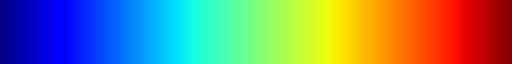

In [49]:
cmap

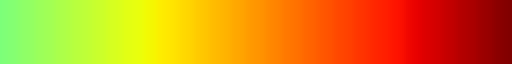

In [50]:
new_cmap

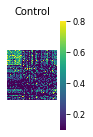

In [191]:
plt.figure(figsize=(7,2))
plt.subplots_adjust(wspace=0.05)

plt.subplot(1, 6, 1);
plt.title('Control')
sns.heatmap(ctrl_gxg.loc[all_selected_genes, all_selected_genes], vmin=0.1, vmax=0.8, cmap='viridis')
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.savefig('ifnb_coex_tps_cbar.png', bbox_inches='tight', dpi=500)

### Setup memento

In [21]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [22]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [23]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

### Check simple examples in coexpression

In [24]:
adata = adata[adata.obs['ct'] == 'C'].copy()
memento.create_groups(adata, label_columns=['donor', 'stim'])
memento.compute_1d_moments(adata, min_perc_group=.9)
memento.compute_2d_moments(adata, [('JUNB', 'LYZ')])

moments = memento.get_2d_moments(adata, groupby='stim')

In [25]:
moments

,gene_1,gene_2,stim_lambda,stim_gamma,stim_alpha,stim_beta,stim_control
0,JUNB,LYZ,-0.049192,-0.032029,0.001502,-0.017261,-0.08325


### Read 1D HT results

In [26]:
cts = ['C', 'B', 'BC', 'all_ct']
tps = [ '3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [27]:
def read_result():
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        adata_subset = sc.read(data_path + '/binary_test_latest/C_{}_6.h5ad'.format(stim))
        ht_dict[stim] = memento.get_1d_ht_result(adata_subset)
        ht_dict[stim]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['de_pval'])
        ht_dict[stim]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['dv_pval'])
        moments_dict[stim] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [28]:
ht, moments = read_result()

KeyError: 'test_genes'

In [ ]:
t1_de_genes = ht['beta'].query('de_coef > 0.5 & de_fdr < 0.05')
t2_de_genes = ht['gamma'].query('de_coef > 0.5 & de_fdr < 0.05')

In [ ]:
# save 1d result table
all_stims = []
for stim in stims:
    
    df = ht[stim]
    df['stim'] = stim
    all_stims.append(df)
all_stims = pd.concat(all_stims)

In [ ]:
all_stims.query('dv_fdr < 0.05').gene.drop_duplicates().shape

In [ ]:
all_stims.query('de_fdr < 0.01').gene.drop_duplicates().shape

In [ ]:
# all_stims.query('de_fdr < 0.01 | dv_fdr < 0.1').to_csv(data_path + '../tables/Supplemetary_Table_1_HTEC_DM_DV.csv', index=False)

### Coexpression

In [19]:
def get_gxg_matrix(adata, genes):

    memento.compute_2d_moments(adata, list(itertools.combinations(genes, 2)))
    
    moments = memento.get_2d_moments(adata, groupby='group')
    
    gxg_matrix = pd.DataFrame(index=genes, columns=genes)
    for idx, row in moments.iterrows():
        gxg_matrix.loc[row['gene_1'], row['gene_2']] = row['group_1']
        gxg_matrix.loc[row['gene_2'], row['gene_1']] = row['group_1']
    gxg_matrix = gxg_matrix.fillna(0.0)
#     gxg_matrix = moments.pivot('gene_1', 'gene_2', 'group_1').fillna(0.0)
#     gxg_matrix[gxg_matrix.columns] = gxg_matrix.values + gxg_matrix.values.T
    gxg_matrix = gxg_matrix.loc[list(set(gxg_matrix.columns) & set(gxg_matrix.index)), list(set(gxg_matrix.columns) & set(gxg_matrix.index))]
    
    return gxg_matrix

In [20]:
ct = ['C']
adata_ctrl = adata.copy()[
    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['control'])].copy()
adata_stim = adata.copy()[
    adata.obs.time.isin(['6']) & \
    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['beta'])].copy()
adata_gamma = adata.copy()[
    adata.obs.time.isin(['6']) & \
    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['gamma'])].copy()
adata_ctrl.obs['group'] = 1
adata_stim.obs['group'] = 1
adata_gamma.obs['group'] = 1

memento.create_groups(adata_ctrl, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)
memento.create_groups(adata_stim, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)
memento.create_groups(adata_gamma, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_gamma, min_perc_group=.9)


gene_list = list( set(adata_ctrl.var.index) & set(adata_stim.var.index) & set(t1_de_genes.gene.tolist() ))

ctrl_gxg = get_gxg_matrix(adata_ctrl, gene_list)
stim_gxg = get_gxg_matrix(adata_stim, gene_list)
# gamma_gxg = get_gxg_matrix(adata_gamma, gene_list)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWa

### Cluster the stim data, see the control-stim matched correlations

In [21]:
from sklearn.cluster import AgglomerativeClustering

In [22]:
# num_cluster = 4

In [23]:
# working params: distance_threshold=15
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=15).fit(ctrl_gxg.clip(upper=1, lower=-1))
# keep cluster 3
for cluster in range(clustering.labels_.max()+1):
    selector = np.where(clustering.labels_==cluster)[0]
    selected_stim_gxg = stim_gxg.iloc[selector, selector]
    selected_ctrl_gxg = ctrl_gxg.iloc[selector, selector]

    print(cluster, selector.shape[0], selected_stim_gxg.mean().mean(), selected_ctrl_gxg.mean().mean())
with open('ctrl_clustering.pkl','wb') as f:
    pkl.dump(clustering, f)

# with open('ctrl_clustering.pkl','rb') as f:
#     clustering = pkl.load(f)

0 66 0.2693050983091503 0.1193512915652339
1 66 0.21158346559875335 0.15156131313703125
2 73 0.3122118074614756 0.27017446725861993
3 36 0.4292436543388385 0.3079232965322828
4 28 0.4063141517340657 0.37455896867494853
5 40 0.24972196490147244 0.21407262341368613
6 103 0.1440406448379398 0.03988763683479729
7 72 0.5704343368481162 0.5361414948166874
8 32 0.179903446016573 0.1257902268940423
9 43 0.3458875650081233 0.27101361542192265
10 56 0.44754502902273124 0.4312678690815409
11 1 0.0 0.0
12 1 0.0 0.0


In [24]:
clustering.labels_[ctrl_gxg.index.tolist().index('STAT2')]

2

In [25]:
clustering.labels_[ctrl_gxg.index.tolist().index('MX1')]

7

In [26]:
canonical_genes = ctrl_gxg.index[clustering.labels_==7].tolist() #+ ctrl_gxg.index[clustering.labels_==10].tolist()

In [27]:
print(canonical_genes)

['GBP4', 'ETV7', 'PSMB8', 'HELZ2', 'SAMD9L', 'NUB1', 'ISG15', 'IFI35', 'NT5C3A', 'IFIT1', 'SP110', 'TAP1', 'PARP9', 'IFI16', 'RNF213', 'OASL', 'IFI6', 'NUPR1', 'APOL1', 'IFIH1', 'IFIT3', 'IFIT2', 'SAMD9', 'ISG20', 'STAT1', 'OAS2', 'HERC6', 'USP18', 'IRF9', 'HERC5', 'XAF1', 'PSMB9', 'HLA-E', 'BST2', 'EPSTI1', 'UBE2L6', 'ADAR', 'U62317.4', 'IRF7', 'PARP14', 'APOL6', 'GBP1', 'OAS1', 'IFI44', 'PLSCR1', 'SPATS2L', 'MX1', 'OAS3', 'IFITM3', 'WARS', 'IFI44L', 'APOBEC3G', 'DDX58', 'DDX60L', 'IFI27', 'CD38', 'OPTN', 'LAP3', 'EIF2AK2', 'SHFL', 'PLAAT2', 'MX2', 'CMPK2', 'RSAD2', 'MYD88', 'TRIM22', 'IFITM1', 'SP100', 'RTP4', 'IDO1', 'PARP12', 'DDX60']


In [28]:
subset_stim_gxg = stim_gxg.loc[list(set(stim_gxg.index)-set(canonical_genes)), : ].loc[: , list(set(stim_gxg.index)-set(canonical_genes))]
subset_ctrl_gxg = ctrl_gxg.loc[list(set(stim_gxg.index)-set(canonical_genes)), : ].loc[: , list(set(stim_gxg.index)-set(canonical_genes))]

In [29]:
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=15).fit(subset_stim_gxg.clip(upper=1, lower=-1))

# keep cluster 3
for cluster in range(clustering.labels_.max()+1):
    selector = np.where(clustering.labels_==cluster)[0]
    selected_subset_stim_gxg = subset_stim_gxg.iloc[selector, selector]
    selected_subset_ctrl_gxg = subset_ctrl_gxg.iloc[selector, selector]

    print(cluster, selector.shape[0], selected_subset_stim_gxg.mean().mean(), selected_subset_ctrl_gxg.mean().mean())
with open('stim_clustering.pkl','wb') as f:
    pkl.dump(clustering, f)

0 60 0.5854549681731079 0.2979394534123458
1 72 0.519878449848138 0.1816760657861927
2 61 0.4277474059895702 0.1657666558419037
3 80 0.2536502953377987 0.13394642691289754
4 28 0.09001529855008138 0.0565566900076162
5 77 0.2946240870426933 0.18598103202909824
6 40 0.1772806042580879 0.08807475227780068
7 46 0.2657231000746265 0.07287158191130723
8 46 0.3986024676335609 0.16912324986371022
9 35 0.21539205358235197 0.05691184697208647


In [30]:
clustering.labels_[subset_stim_gxg.index.tolist().index('HLA-A')]

1

In [31]:
noncanonical_genes_1 = subset_stim_gxg.index[clustering.labels_==1].tolist()
noncanonical_genes_2 = subset_stim_gxg.index[clustering.labels_==2].tolist()

noncanonical_genes_3 = subset_stim_gxg.index[clustering.labels_==8].tolist()

# noncanonical_genes_2 = subset_stim_gxg.index[clustering.labels_==6].tolist()

In [32]:
all_selected_genes = canonical_genes + noncanonical_genes_1 + noncanonical_genes_3 + noncanonical_genes_2

In [33]:
print(noncanonical_genes_2)

['PI4K2B', 'XPNPEP1', 'STX4', 'WDFY1', 'TBC1D1', 'GSDMB', 'ATP13A3', 'RIPK1', 'TAP2', 'RABGAP1L', 'PALM2-AKAP2', 'R3HCC1L', 'SCARB2', 'PLEKHA7', 'ICK', 'TMEM175', 'NADK', 'USP42', 'CFLAR', 'FNDC3A', 'RBMS2', 'KARS', 'AC009133.1', 'TAPBP', 'PNPT1', 'LAMP3', 'NFE2L3', 'GTPBP1', 'PRKD2', 'KPNB1', 'XRN1', 'CHROMR', 'GNB4', 'C5orf56', 'PARP8', 'PTK2B', 'SLFN5', 'MTG1', 'TRIM26', 'PML', 'HSH2D', 'JAK2', 'CMTR1', 'OSBPL5', 'SLC25A28', 'ZFYVE26', 'TRIM21', 'SCLT1', 'OGFR', 'ZNFX1', 'DOP1A', 'LINC01138', 'BTN3A1', 'HCP5', 'HIST2H2BE', 'TBX1', 'BISPR', 'SLC6A6', 'SCIN', 'TRAFD1', 'UNC93B1']


In [34]:
np.fill_diagonal(ctrl_gxg.values, 1)
np.fill_diagonal(stim_gxg.values, 1)

([], [])

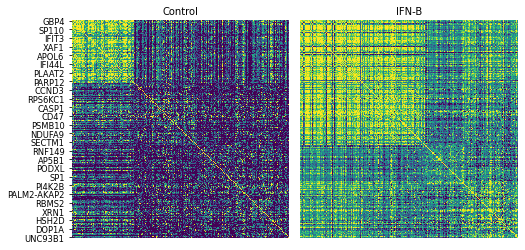

In [35]:
plt.figure(figsize=(8,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(1, 2, 1);
plt.title('Control')
sns.heatmap(ctrl_gxg.loc[all_selected_genes, all_selected_genes], vmin=0.1, vmax=0.7, cmap='viridis', cbar=None)
plt.axis('equal')
plt.xticks([])

plt.subplot(1, 2, 2);
plt.title('IFN-B')
sns.heatmap(stim_gxg.loc[all_selected_genes, all_selected_genes], vmin=0.1, vmax=0.7, cmap='viridis', cbar=None)
plt.axis('equal')
plt.xticks([])
plt.yticks([])

In [36]:
# with open('canonical_isgs.pkl', 'wb') as f:
#     pkl.dump(canonical_genes, f)
# with open('noncanonical_isgs.pkl', 'wb') as f:
#     pkl.dump(noncanonical_genes_1, f)

### Investigate other timepoints - coexpression

In [173]:
tps = ['3', '6', '9', '24', '48']

In [175]:
gxg_matrices = {}
for tp in tps:
    
    adata_tp = adata.copy()[
        adata.obs.time.isin([tp]) & \
        adata.obs.ct.isin(ct) & \
        adata.obs.stim.isin(['beta'])].copy()
    adata_tp.obs['group'] = 1

    memento.create_groups(adata_tp, label_columns=['donor', 'group'])
    memento.compute_1d_moments(adata_tp, min_perc_group=.9)
    
    tp_gene_list = [g for g in all_selected_genes if g in adata_tp.var.index]

    gxg_matrices[tp] = get_gxg_matrix(adata_tp, tp_gene_list).loc[tp_gene_list, tp_gene_list]
    np.fill_diagonal(gxg_matrices[tp].values, 1)


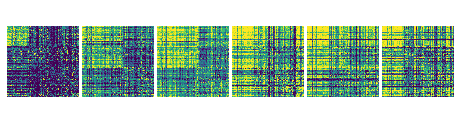

In [180]:
plt.figure(figsize=(8,2))
plt.subplots_adjust(wspace=0.05)

plt.subplot(1, 6, 1);
# plt.title('Control')
sns.heatmap(ctrl_gxg.loc[all_selected_genes, all_selected_genes], vmin=0.1, vmax=0.7, cmap='viridis', cbar=None)
plt.axis('equal')
plt.xticks([])
plt.yticks([])

for i, tp in enumerate(tps):

    plt.subplot(1, 6, i+2);
#     plt.title('IFN-B ' + tps[i] + 'hr')
    sns.heatmap(gxg_matrices[tp], vmin=0.1, vmax=0.7, cmap='viridis', cbar=None)
    plt.axis('equal')
    plt.xticks([]);
    plt.yticks([])
plt.savefig('ifnb_coex_tps.png', bbox_inches='tight', dpi=500)

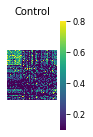

In [191]:
plt.figure(figsize=(7,2))
plt.subplots_adjust(wspace=0.05)

plt.subplot(1, 6, 1);
plt.title('Control')
sns.heatmap(ctrl_gxg.loc[all_selected_genes, all_selected_genes], vmin=0.1, vmax=0.8, cmap='viridis')
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.savefig('ifnb_coex_tps_cbar.png', bbox_inches='tight', dpi=500)

### Mean single cell heatmaps

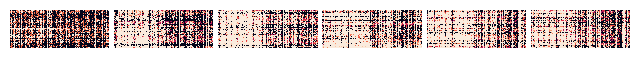

In [142]:
plt.figure(figsize=(8,0.5))
plt.subplots_adjust(wspace=0.05)
vmax=1
plt.subplot(1, 6, 1);
sns.heatmap(np.log(adata_ctrl[:, all_selected_genes].X.todense()+1), cbar=None, vmax=vmax)
plt.xticks([])
plt.yticks([])


for i, tp in enumerate(tps):
    
    plt.subplot(1, 6, i+2);
    adata_tp = adata.copy()[
        adata.obs.time.isin([tp]) & \
        adata.obs.ct.isin(ct) & \
        adata.obs.stim.isin(['beta'])].copy()
    sc.pp.normalize_total(adata_tp)
    sc.pp.log1p(adata_tp)
    tp_gene_list = [g for g in all_selected_genes if g in adata_tp.var.index]
    sns.heatmap(adata_tp[:, tp_gene_list].X.todense(), cbar=None, vmax=vmax)
    plt.xticks([]);
    plt.yticks([])
plt.savefig('ifnb_expr_tps.png', bbox_inches='tight', dpi=300)

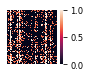

In [190]:
plt.figure(figsize=(7,1))
plt.subplots_adjust(wspace=0.05)
vmax=1
plt.subplot(1, 6, 1);
sns.heatmap(np.log(adata_ctrl[:, gene_list].X.todense()+1), vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.savefig('ifnb_expr_tps_cbar.png', bbox_inches='tight', dpi=300)

### Tonic sensitivity

In [23]:
with open('canonical_isgs.pkl', 'rb') as f:
    canonical_genes = pkl.load(f)

In [16]:
tonic_sensitivity_df = pd.read_csv('tonic_isg.txt', sep='\t')
tonic_sensitivity_df['gene'] = tonic_sensitivity_df['GeneSymbol'].str.upper()

In [17]:
tonic_sensitivity_df = pd.read_csv('tonic_isg.txt', sep='\t')
tonic_sensitivity_df['gene'] = tonic_sensitivity_df['GeneSymbol'].str.upper()
tonic_sensitivity_df = tonic_sensitivity_df[['gene', 'TonicIndex']].rename(columns={'TonicIndex':'Tonic Sensitivity'})

In [18]:
tonic_sensitivity_df['Tonic Sensitivity'] = np.log(tonic_sensitivity_df['Tonic Sensitivity'])

In [19]:
# tonic_sensitivity_df = moments['beta'][1].rename(columns={'time_step_0':'Baseline variability'}).merge(tonic_sensitivity_df, on='gene').query('gene in @t1_de_genes.gene.tolist()')

In [134]:
all_genes = moments['beta'][1].gene.tolist()

In [20]:
tonic_sensitivity_df = tonic_sensitivity_df#.query('gene in @all_genes').copy()

In [21]:
tonic_sensitivity_df.shape

(218, 2)

In [24]:
tonic_sensitivity_df['group'] = tonic_sensitivity_df['gene'].apply(lambda x: 'canon' if x in canonical_genes else 'non\ncanon')

In [25]:
tonic_sensitivity_df.group.value_counts()

non\ncanon    168
canon          50
Name: group, dtype: int64

In [28]:
stats.mannwhitneyu(
    tonic_sensitivity_df.query('group=="canon"')['Tonic Sensitivity'],
    tonic_sensitivity_df.query('group!="canon"')['Tonic Sensitivity']
    )

MannwhitneyuResult(statistic=6672.0, pvalue=2.734276727704463e-10)

<AxesSubplot:xlabel='group', ylabel='Tonic Sensitivity'>

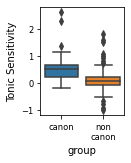

In [26]:
plt.figure(figsize=(1.5,2))
sns.boxplot(x='group', y='Tonic Sensitivity', data=tonic_sensitivity_df)

In [148]:
stats.mannwhitneyu(tonic_sensitivity_df.query('group == "canon"')['Tonic Sensitivity'], tonic_sensitivity_df.query('group == "non\\ncanon"')['Tonic Sensitivity'])

MannwhitneyuResult(statistic=1728.0, pvalue=1.3671383638522417e-10)

### Baseline variability

In [149]:
baseline = moments['beta'][1].query('gene in @all_selected_genes').copy()

In [152]:
baseline['group'] = baseline['gene'].apply(lambda x: 'canon' if x in canonical_genes else 'non\ncanon')

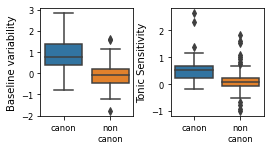

In [168]:
plt.figure(figsize=(4,2))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1, 2, 1)
sns.boxplot(x='group', y='time_step_0', data=baseline);
plt.xlabel(None);
plt.ylabel('Baseline variability')
plt.subplot(1, 2, 2)

sns.boxplot(x='group', y='Tonic Sensitivity', data=tonic_sensitivity_df)
plt.xlabel(None);
plt.savefig('baseline_and_tonic.pdf', bbox_inches='tight')

### Differential correlation for canonical and non-canonical ISGs

restart kernel

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_rows', 600)

In [2]:
import functools

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/hbec/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [31]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Get data

In [31]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [32]:
# adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [33]:
adata.shape

(69958, 36601)

In [34]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [35]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])
# adata_processed.obs['ct'] = adata_processed.obs['cell_type'].apply(lambda x: converter[x])

### Setup memento

In [12]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [13]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [14]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

In [15]:
ct = ['C']


In [16]:
with open('canonical_isgs.pkl', 'rb') as f:
    canonical_genes = pkl.load(f)
with open('noncanonical_isgs.pkl', 'rb') as f:
    noncanonical_genes = pkl.load(f)

In [17]:
adata_tp = adata.copy()[
    adata.obs.time.isin(['0', '6']) & \
    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['beta', 'control'])].copy()
adata_tp.obs['tp'] = adata_tp.obs['time'].apply(lambda x: {'0':0, '6':1}[x])

memento.create_groups(adata_tp, label_columns=['donor', 'tp'])
memento.compute_1d_moments(adata_tp, min_perc_group=.9)

meta_df = memento.get_groups(adata_tp)
treatment = meta_df[['tp']]
covariate = pd.DataFrame(np.ones((treatment.shape[0], 1)), columns=['intercept'])

memento.compute_2d_moments(adata_tp, list(itertools.combinations(canonical_genes, 2)))
memento.ht_2d_moments(
        adata_tp, 
        covariate=covariate,
        treatment=treatment,
        num_boot=10000, 
        verbose=1,
        num_cpus=80,
        resample_rep=False,
        approx=False)
canonical_result = memento.get_2d_ht_result(adata_tp)

memento.compute_2d_moments(adata_tp, list(itertools.combinations(noncanonical_genes, 2)))
memento.ht_2d_moments(
        adata_tp, 
        covariate=covariate,
        treatment=treatment,
        num_boot=10000, 
        verbose=1,
        num_cpus=80,
        resample_rep=False,
        approx=False)
noncanonical_result = memento.get_2d_ht_result(adata_tp)

[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:   10.0s
[Parallel(n_jobs=80)]: Done 290 tasks      | elapsed:   18.9s
[Parallel(n_jobs=80)]: Done 640 tasks      | elapsed:   33.3s
[Parallel(n_jobs=80)]: Done 1090 tasks      | elapsed:   51.0s
[Parallel(n_jobs=80)]: Done 1640 tasks      | elapsed:  1.2min
[Parallel(n_jobs=80)]: Done 2290 tasks      | elapsed:  1.6min
[Parallel(n_jobs=80)]: Done 2556 out of 2556 | elapsed:  1.8min finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  40 tasks      | elapsed:    2.8s
[Parallel(n_jobs=80)]: Done 290 tasks      | elapsed:   10.4s
[Parallel(n_jobs=80)]: Done 640 tasks      | elapsed:   17.5s
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg/memento/hypothesis_test.py:239: RuntimeWarning: invalid value encountered in divide
/home/ssm-user/anaconda3/envs/single_cell/lib/pyt

In [18]:
canonical_result['type'] = 'canonical'
noncanonical_result['type'] = 'noncanonical'

dc_result = pd.concat([canonical_result, noncanonical_result])

In [19]:
dc_result['corr_fdr'] = memento.util._fdrcorrect(dc_result['corr_pval'])

In [20]:
dc_result['sig'] = dc_result['corr_fdr'] < 0.1

In [21]:
# dc_result.query('corr_fdr < 0.1').to_csv(data_path + '../tables/Supplementary_Table_2_HTEC_DC.csv', index=False)

In [22]:
len(canonical_result)

2556

In [23]:
len(noncanonical_result)

2556

In [44]:
len(noncanonical_genes)

72

In [41]:
dc_result.groupby('type').size()

type
canonical       2556
noncanonical    2556
dtype: int64

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg/memento/hypothesis_test.py:236: RuntimeWarning: invalid value encountered in true_divide
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [40]:
dc_result.groupby('type').sig.mean()

type
canonical       0.164710
noncanonical    0.336463
Name: sig, dtype: float64

In [38]:
dc_result.query('corr_fdr < 0.1').type.value_counts()

noncanonical    860
canonical       421
Name: type, dtype: int64

In [28]:
dc_result.head(5)

,gene_1,gene_2,tx,corr_coef,corr_se,corr_pval
0,GBP4,ETV7,tp,-0.039746,0.243536,0.858014
1,GBP4,PSMB8,tp,-0.069037,0.143860,0.629237
2,GBP4,HELZ2,tp,-0.023613,0.170969,0.889511
3,GBP4,SAMD9L,tp,-0.180961,0.139104,0.282472
4,GBP4,NUB1,tp,0.241124,0.192093,0.195280


### Perform 1D tests

In [ ]:
memento.ht_1d_moments(
        adata_tp, 
        covariate=covariate,
        treatment=treatment,
        num_boot=10000, 
        verbose=1,
        num_cpus=80,
        resample_rep=False,
        approx=False)

KeyError: 'AP003396.1'

In [42]:
memento.compute_2d_moments(adata_tp, list(zip(np.random.choice(adata_tp.var.index, 1000), np.random.choice(adata_tp.var.index, 1000))))

memento.ht_2d_moments(
        adata_tp, 
        covariate=covariate,
        treatment=treatment,
        num_boot=10000, 
        verbose=1,
        num_cpus=80,
        resample_rep=False,
        approx=False)
random_result = memento.get_2d_ht_result(adata_tp)

[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  41 tasks      | elapsed:    9.8s
[Parallel(n_jobs=80)]: Done 291 tasks      | elapsed:   14.1s
[Parallel(n_jobs=80)]: Done 641 tasks      | elapsed:   19.9s
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg/memento/hypothesis_test.py:239: RuntimeWarning: invalid value encountered in divide
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg/memento/hypothesis_test.py:239: RuntimeWarning: invalid value encountered in divide
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype,

In [43]:
de_result = memento.get_1d_ht_result(adata_tp)

In [44]:
merged = random_result\
    .merge(de_result[['gene', 'de_coef']].rename(columns={'gene':'gene_1'}), on='gene_1')\
    .merge(de_result[['gene', 'de_coef']].rename(columns={'gene':'gene_2'}), on='gene_2')

In [45]:
merged

,gene_1,gene_2,tx,corr_coef,corr_se,corr_pval,de_coef_x,de_coef_y
0,CNIH2,PSPH,tp,-0.293168,0.217046,0.176282,-0.016014,-0.334247
1,HAGH,DHX16,tp,0.379896,0.276873,0.170183,-0.457041,-0.251929
2,SUMO2,DNAJA2,tp,0.284774,0.118060,0.020698,-0.079010,-0.271428
3,MAPK15,KHSRP,tp,0.390389,0.250495,0.119188,0.256589,0.229540
4,EFTUD2,LRRC6,tp,0.389049,0.260608,0.139186,-0.041564,-0.292117
...,...,...,...,...,...,...,...,...
995,PRRT2,HNRNPC,tp,-0.209060,0.206115,0.305569,0.226186,-0.187766
996,ADAM17,SPATS2,tp,-0.149979,0.247312,0.537846,0.381372,-0.450541
997,DNAJA2,PIK3C3,tp,-0.009784,0.341501,0.975902,-0.271428,-0.056945
998,ACBD7,SLC25A12,tp,0.588158,0.305291,0.061894,-0.105356,0.075922


In [46]:
stats.pearsonr(merged.dropna()['de_coef_x']+merged.dropna()['de_coef_y'], merged.dropna()['corr_coef'])

PearsonRResult(statistic=0.0526859336592988, pvalue=0.09621676610246142)

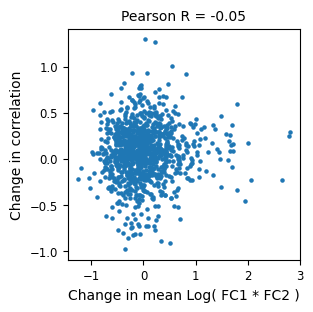

In [62]:
plt.figure(figsize=(3,3))
plt.scatter(merged['de_coef_y'] + merged['de_coef_x'], merged['corr_coef'], s=5)
plt.xlabel('Change in mean Log( FC1 * FC2 )')
plt.ylabel('Change in correlation');
plt.title('Pearson R = {:.2f}'.format(-0.05))
plt.savefig('mean_vs_corr.png', dpi=300, bbox_inches='tight')

In [27]:
dc_result

,gene_1,gene_2,tx,corr_coef,corr_se,corr_pval,type,corr_fdr,sig
0,GBP4,ETV7,tp,-0.039747,0.244955,0.867213,canonical,0.928612,False
1,GBP4,PSMB8,tp,-0.069038,0.146059,0.629137,canonical,0.772927,False
2,GBP4,HELZ2,tp,-0.023613,0.173394,0.892011,canonical,0.944514,False
3,GBP4,SAMD9L,tp,-0.180962,0.137939,0.286071,canonical,0.475422,False
4,GBP4,NUB1,tp,0.241123,0.191647,0.191981,canonical,0.372875,False
...,...,...,...,...,...,...,...,...,...
2551,SECTM1,TNFRSF14,tp,-0.037725,0.215520,0.866613,noncanonical,0.928359,False
2552,SECTM1,PSME2,tp,-0.034025,0.162830,0.838116,noncanonical,0.910616,False
2553,TCHP,TNFRSF14,tp,0.231348,0.232572,0.321668,noncanonical,0.509565,False
2554,TCHP,PSME2,tp,0.032754,0.136638,0.805219,noncanonical,0.892322,False


In [26]:
de_result

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,LINC01409,tp,0.134238,307.281754,0.998598,0.194505,0.725365,0.750054
1,NOC2L,tp,-0.068248,360.110016,0.999874,-0.506629,0.682841,0.398770
2,HES4,tp,1.024935,14.589969,0.999200,-0.173837,0.132669,0.193281
3,ISG15,tp,3.162366,9.049667,0.999100,-3.944580,0.176483,0.000013
4,AGRN,tp,0.973582,72.690042,0.984530,-0.130689,0.324352,0.658334
...,...,...,...,...,...,...,...,...
9674,MT-ND4,tp,-0.232830,9.927238,1.000000,-0.004939,0.082061,0.951105
9675,MT-ND5,tp,-0.479037,15.910001,0.998000,0.102461,0.093802,0.277972
9676,MT-ND6,tp,0.270165,30.525812,0.993601,-0.161945,0.230073,0.488051
9677,MT-CYB,tp,-0.516569,9.050443,1.000000,0.399219,0.080477,0.000292


### DE vs DV coefficient plots for canonical ISGs

Use 0.0.6

In [ ]:
with open('canonical_isgs.pkl', 'rb') as f:
    canonical_genes = pkl.load(f)
with open('noncanonical_isgs.pkl', 'rb') as f:
    noncanonical_genes = pkl.load(f)

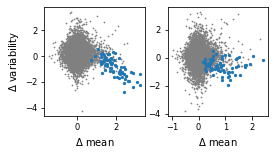

In [42]:
plt.figure(figsize=(4, 2))
plt.subplots_adjust(wspace=0.23)

plt.subplot(1, 2, 1)

tp = '6'
stim = 'beta'
plt.scatter(
    ht[stim]['de_coef'],
    ht[stim]['dv_coef'],
    s=0.5, color='gray'
)

plt.scatter(
    ht[stim].query('de_fdr < 0.01 & gene in @canonical_genes')['de_coef'],
    ht[stim].query('de_fdr < 0.01 & gene in @canonical_genes')['dv_coef'],
    s=5
)
plt.xlabel(r'$\Delta$ mean')
plt.ylabel(r'$\Delta$ variability')

plt.subplot(1, 2, 2)

tp = '6'
stim = 'gamma'
plt.scatter(
    ht[stim]['de_coef'],
    ht[stim]['dv_coef'],
    s=0.5, color='gray'
)

plt.scatter(
    ht[stim].query('de_fdr < 0.01 & gene in @canonical_genes')['de_coef'],
    ht[stim].query('de_fdr < 0.01 & gene in @canonical_genes')['dv_coef'],
    s=5
)
plt.xlabel(r'$\Delta$ mean')
plt.savefig('de_vs_dv_canonical.png', bbox_inches='tight', dpi=300)

In [41]:
(ht['gamma'].query('de_fdr < 0.01 & gene in @canonical_genes').dv_fdr < 0.1).mean()

0.3939393939393939

In [40]:
(ht['beta'].query('de_fdr < 0.01 & gene in @canonical_genes').dv_fdr < 0.1).mean()

0.7777777777777778